## Install Package yang diperlukan

In [1]:
!pip install jcopdl
!pip install tqdm

  Created wheel for jcopdl: filename=jcopdl-1.1.9-py2.py3-none-any.whl size=16925 sha256=16b2ef7329ff41a02bde3f9b7dfecdb238130b6da493afa875300ab468b04efb
  Stored in directory: /root/.cache/pip/wheels/bb/fd/9d/fc72bcf569000eabd487e654fdf55b587e66882b60eaa5693b
Successfully built jcopdl


## Import Pakcage yang diperlukan

In [2]:
import torch
from torch import nn, optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

from jcopdl.callback import Callback, set_config
from jcopdl.layers import linear_block
from jcopdl.layers import linear_block, conv_block

from google.colab import files
import zipfile,os

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

## Ekstraksi File Datasets

In [3]:
local_zip = '/content/CIFAR10.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/content/')
zip_ref.close()

base_dir = ('/content/cifar10/cifar10')
os.listdir(base_dir)

['train', 'test']

## Datasets dan Dataloader

In [9]:
bs = 512
crop_size = 32

transform_train = transforms.Compose([
    transforms.CenterCrop(crop_size),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.RandomRotation(10),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor()
])

transform_test = transforms.Compose([
    transforms.CenterCrop(crop_size),
    transforms.ToTensor()
])

train_set = datasets.ImageFolder("/content/cifar10/cifar10/train", transform=transform_train)
trainloader = DataLoader(train_set, batch_size=bs, shuffle=True)

test_set = datasets.ImageFolder("/content/cifar10/cifar10/test", transform=transform_test)
testloader = DataLoader(test_set, batch_size=bs, shuffle=True)

In [10]:
# Cek Data
images, label = next(iter(trainloader))
images.shape

torch.Size([512, 3, 32, 32])

In [11]:
# label
label2cat = train_set.classes
label2cat

['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

In [12]:
len(label2cat)

10

## Buat Arsitektur CNN

In [13]:
class CifarCNN(nn.Module):
    def __init__(self, input_size, hidden1, hidden2, output_size, drout):
        super().__init__()
        self.conv = nn.Sequential(
            # 3x32x32
            nn.Conv2d(3, 32, kernel_size=(3,3), padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2,2), stride=2),
            # 32x16x16
            nn.Conv2d(32, 64, kernel_size=(3,3), padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2,2), stride=2),
            #64x8x8
            nn.Conv2d(64, 128, kernel_size=(3,3), padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2,2), stride=2),
            #128x4x4
            nn.Flatten()
        )
        
        self.fc = nn.Sequential(
            nn.Linear(in_features=input_size, out_features=hidden1),
            nn.ReLU(),
            nn.Dropout(drout),
            nn.Linear(hidden1, hidden2),
            nn.ReLU(),
            nn.Dropout(drout),
            nn.Linear(hidden2, output_size),
            nn.LogSoftmax()
        )
        
    def forward(self, x):
        return self.fc(self.conv(x))

In [15]:
config = set_config({
    "bs" : 512,
    "crop_size" : 32,
    "input_layer" : 2048,
    "hidden1" : 1024,
    "hidden2" : 512,
    "output_size" : len(label2cat),
    "drout" : 0.2
})

## Training Preparation

In [16]:
model = CifarCNN(config.input_layer, config.hidden1, config.hidden2, config.output_size, config.drout).to(device)
criterion = nn.NLLLoss()
optimizer = optim.AdamW(model.parameters(), lr=0.002)
callback = Callback(model, config, outdir="model_weight", early_stop_patience=25, plot_every=50)

## Proses Training

In [17]:
from tqdm.auto import tqdm

def loop_fn(mode, dataset, dataloader, model, criterion, optimizer, device):
    if mode == "train":
        model.train()
    elif mode == "test":
        model.eval()
    cost = correct = 0
    for feature, target in tqdm(dataloader, desc=mode.title()):
        feature, target = feature.to(device), target.to(device)
        output = model(feature)
        loss = criterion(output, target)
        
        if mode == "train":
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        
        cost += loss.item() * feature.shape[0]
        correct += (output.argmax(1) == target).sum().item()
    cost = cost / len(dataset)
    acc = correct / len(dataset)
    return cost, acc

/usr/local/lib/python3.6/dist-packages/torch/nn/modules/container.py:117: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)




Epoch     1
Train_cost  = 1.8076 | Test_cost  = 1.3852 | Train_score = 0.3262 | Test_score = 0.4883 |




Epoch     2
Train_cost  = 1.3823 | Test_cost  = 1.2247 | Train_score = 0.4976 | Test_score = 0.5519 |




Epoch     3
Train_cost  = 1.1763 | Test_cost  = 1.0338 | Train_score = 0.5793 | Test_score = 0.6309 |




Epoch     4
Train_cost  = 1.0416 | Test_cost  = 0.9456 | Train_score = 0.6306 | Test_score = 0.6633 |




Epoch     5
Train_cost  = 0.9572 | Test_cost  = 0.8740 | Train_score = 0.6625 | Test_score = 0.6903 |




Epoch     6
Train_cost  = 0.8848 | Test_cost  = 0.8416 | Train_score = 0.6912 | Test_score = 0.7058 |




Epoch     7
Train_cost  = 0.8297 | Test_cost  = 0.7938 | Train_score = 0.7087 | Test_score = 0.7271 |




Epoch     8
Train_cost  = 0.7722 | Test_cost  = 0.7845 | Train_score = 0.7287 | Test_score = 0.7253 |
==> EarlyStop patience =  1 | Best test_score: 0.7271




Epoch     9
Train_cost  = 0.7418 | Test_cost  = 0.7480 | Train_score = 0.7385 | Test_score = 0.7394 |




Epoch    10
Train_cost  = 0.6950 | Test_cost  = 0.7605 | Train_score = 0.7578 | Test_score = 0.7411 |




Epoch    11
Train_cost  = 0.6566 | Test_cost  = 0.6921 | Train_score = 0.7696 | Test_score = 0.7622 |




Epoch    12
Train_cost  = 0.6366 | Test_cost  = 0.6902 | Train_score = 0.7774 | Test_score = 0.7652 |




Epoch    13
Train_cost  = 0.6083 | Test_cost  = 0.6824 | Train_score = 0.7866 | Test_score = 0.7642 |
==> EarlyStop patience =  1 | Best test_score: 0.7652




Epoch    14
Train_cost  = 0.5900 | Test_cost  = 0.6902 | Train_score = 0.7912 | Test_score = 0.7641 |
==> EarlyStop patience =  2 | Best test_score: 0.7652




Epoch    15
Train_cost  = 0.5572 | Test_cost  = 0.6659 | Train_score = 0.8047 | Test_score = 0.7701 |




Epoch    16
Train_cost  = 0.5282 | Test_cost  = 0.6515 | Train_score = 0.8138 | Test_score = 0.7790 |




Epoch    17
Train_cost  = 0.5088 | Test_cost  = 0.6878 | Train_score = 0.8225 | Test_score = 0.7733 |
==> EarlyStop patience =  1 | Best test_score: 0.7790




Epoch    18
Train_cost  = 0.4928 | Test_cost  = 0.6839 | Train_score = 0.8275 | Test_score = 0.7744 |
==> EarlyStop patience =  2 | Best test_score: 0.7790




Epoch    19
Train_cost  = 0.4769 | Test_cost  = 0.6538 | Train_score = 0.8300 | Test_score = 0.7833 |




Epoch    20
Train_cost  = 0.4603 | Test_cost  = 0.6599 | Train_score = 0.8387 | Test_score = 0.7861 |




Epoch    21
Train_cost  = 0.4436 | Test_cost  = 0.6469 | Train_score = 0.8421 | Test_score = 0.7892 |




Epoch    22
Train_cost  = 0.4290 | Test_cost  = 0.7016 | Train_score = 0.8477 | Test_score = 0.7776 |
==> EarlyStop patience =  1 | Best test_score: 0.7892




Epoch    23
Train_cost  = 0.4165 | Test_cost  = 0.6622 | Train_score = 0.8518 | Test_score = 0.7882 |
==> EarlyStop patience =  2 | Best test_score: 0.7892




Epoch    24
Train_cost  = 0.4038 | Test_cost  = 0.6715 | Train_score = 0.8584 | Test_score = 0.7938 |




Epoch    25
Train_cost  = 0.3861 | Test_cost  = 0.6594 | Train_score = 0.8627 | Test_score = 0.7937 |
==> EarlyStop patience =  1 | Best test_score: 0.7938




Epoch    26
Train_cost  = 0.3737 | Test_cost  = 0.6813 | Train_score = 0.8674 | Test_score = 0.7917 |
==> EarlyStop patience =  2 | Best test_score: 0.7938




Epoch    27
Train_cost  = 0.3690 | Test_cost  = 0.6985 | Train_score = 0.8700 | Test_score = 0.7836 |
==> EarlyStop patience =  3 | Best test_score: 0.7938




Epoch    28
Train_cost  = 0.3530 | Test_cost  = 0.7001 | Train_score = 0.8744 | Test_score = 0.7874 |
==> EarlyStop patience =  4 | Best test_score: 0.7938




Epoch    29
Train_cost  = 0.3439 | Test_cost  = 0.6940 | Train_score = 0.8791 | Test_score = 0.7900 |
==> EarlyStop patience =  5 | Best test_score: 0.7938




Epoch    30
Train_cost  = 0.3354 | Test_cost  = 0.6935 | Train_score = 0.8817 | Test_score = 0.7895 |
==> EarlyStop patience =  6 | Best test_score: 0.7938




Epoch    31
Train_cost  = 0.3245 | Test_cost  = 0.6753 | Train_score = 0.8855 | Test_score = 0.7961 |




Epoch    32
Train_cost  = 0.3191 | Test_cost  = 0.7090 | Train_score = 0.8873 | Test_score = 0.7953 |
==> EarlyStop patience =  1 | Best test_score: 0.7961




Epoch    33
Train_cost  = 0.3099 | Test_cost  = 0.7244 | Train_score = 0.8891 | Test_score = 0.7923 |
==> EarlyStop patience =  2 | Best test_score: 0.7961




Epoch    34
Train_cost  = 0.3027 | Test_cost  = 0.7000 | Train_score = 0.8930 | Test_score = 0.7974 |




Epoch    35
Train_cost  = 0.2878 | Test_cost  = 0.7079 | Train_score = 0.8968 | Test_score = 0.7995 |




Epoch    36
Train_cost  = 0.2922 | Test_cost  = 0.7295 | Train_score = 0.8963 | Test_score = 0.7952 |
==> EarlyStop patience =  1 | Best test_score: 0.7995




Epoch    37
Train_cost  = 0.2910 | Test_cost  = 0.6975 | Train_score = 0.8978 | Test_score = 0.7955 |
==> EarlyStop patience =  2 | Best test_score: 0.7995




Epoch    38
Train_cost  = 0.2814 | Test_cost  = 0.7219 | Train_score = 0.9018 | Test_score = 0.7940 |
==> EarlyStop patience =  3 | Best test_score: 0.7995




Epoch    39
Train_cost  = 0.2647 | Test_cost  = 0.7485 | Train_score = 0.9071 | Test_score = 0.7926 |
==> EarlyStop patience =  4 | Best test_score: 0.7995




Epoch    40
Train_cost  = 0.2624 | Test_cost  = 0.7716 | Train_score = 0.9060 | Test_score = 0.7898 |
==> EarlyStop patience =  5 | Best test_score: 0.7995




Epoch    41
Train_cost  = 0.2606 | Test_cost  = 0.7435 | Train_score = 0.9079 | Test_score = 0.7900 |
==> EarlyStop patience =  6 | Best test_score: 0.7995




Epoch    42
Train_cost  = 0.2555 | Test_cost  = 0.7254 | Train_score = 0.9089 | Test_score = 0.7944 |
==> EarlyStop patience =  7 | Best test_score: 0.7995




Epoch    43
Train_cost  = 0.2533 | Test_cost  = 0.7454 | Train_score = 0.9122 | Test_score = 0.7953 |
==> EarlyStop patience =  8 | Best test_score: 0.7995




Epoch    44
Train_cost  = 0.2498 | Test_cost  = 0.7537 | Train_score = 0.9096 | Test_score = 0.7971 |
==> EarlyStop patience =  9 | Best test_score: 0.7995




Epoch    45
Train_cost  = 0.2403 | Test_cost  = 0.7392 | Train_score = 0.9147 | Test_score = 0.7988 |
==> EarlyStop patience = 10 | Best test_score: 0.7995




Epoch    46
Train_cost  = 0.2338 | Test_cost  = 0.7462 | Train_score = 0.9174 | Test_score = 0.7996 |




Epoch    47
Train_cost  = 0.2324 | Test_cost  = 0.7678 | Train_score = 0.9174 | Test_score = 0.7980 |
==> EarlyStop patience =  1 | Best test_score: 0.7996




Epoch    48
Train_cost  = 0.2330 | Test_cost  = 0.7618 | Train_score = 0.9181 | Test_score = 0.7922 |
==> EarlyStop patience =  2 | Best test_score: 0.7996




Epoch    49
Train_cost  = 0.2249 | Test_cost  = 0.7480 | Train_score = 0.9217 | Test_score = 0.7996 |
==> EarlyStop patience =  3 | Best test_score: 0.7996




Epoch    50
Train_cost  = 0.2248 | Test_cost  = 0.7753 | Train_score = 0.9206 | Test_score = 0.7928 |


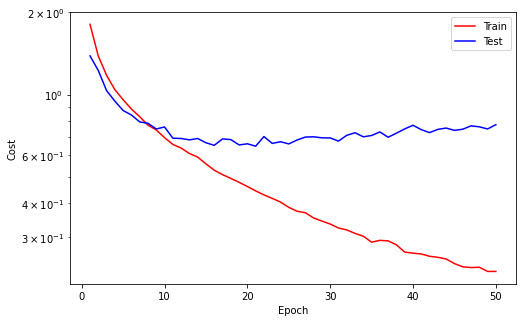

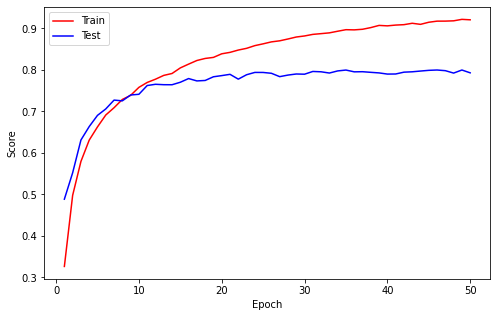

==> EarlyStop patience =  4 | Best test_score: 0.7996




Epoch    51
Train_cost  = 0.2215 | Test_cost  = 0.7496 | Train_score = 0.9206 | Test_score = 0.8021 |




Epoch    52
Train_cost  = 0.2129 | Test_cost  = 0.7536 | Train_score = 0.9240 | Test_score = 0.7962 |
==> EarlyStop patience =  1 | Best test_score: 0.8021




Epoch    53
Train_cost  = 0.2153 | Test_cost  = 0.7687 | Train_score = 0.9241 | Test_score = 0.7962 |
==> EarlyStop patience =  2 | Best test_score: 0.8021




Epoch    54
Train_cost  = 0.2081 | Test_cost  = 0.7841 | Train_score = 0.9268 | Test_score = 0.7980 |
==> EarlyStop patience =  3 | Best test_score: 0.8021




Epoch    55
Train_cost  = 0.2138 | Test_cost  = 0.7800 | Train_score = 0.9251 | Test_score = 0.7987 |
==> EarlyStop patience =  4 | Best test_score: 0.8021




Epoch    56
Train_cost  = 0.2021 | Test_cost  = 0.8216 | Train_score = 0.9288 | Test_score = 0.7896 |
==> EarlyStop patience =  5 | Best test_score: 0.8021




Epoch    57
Train_cost  = 0.2039 | Test_cost  = 0.7886 | Train_score = 0.9270 | Test_score = 0.7977 |
==> EarlyStop patience =  6 | Best test_score: 0.8021




Epoch    58
Train_cost  = 0.2051 | Test_cost  = 0.7718 | Train_score = 0.9286 | Test_score = 0.7985 |
==> EarlyStop patience =  7 | Best test_score: 0.8021




Epoch    59
Train_cost  = 0.2024 | Test_cost  = 0.8124 | Train_score = 0.9288 | Test_score = 0.7979 |
==> EarlyStop patience =  8 | Best test_score: 0.8021




Epoch    60
Train_cost  = 0.1945 | Test_cost  = 0.8065 | Train_score = 0.9322 | Test_score = 0.7984 |
==> EarlyStop patience =  9 | Best test_score: 0.8021




Epoch    61
Train_cost  = 0.1919 | Test_cost  = 0.7991 | Train_score = 0.9319 | Test_score = 0.8004 |
==> EarlyStop patience = 10 | Best test_score: 0.8021




Epoch    62
Train_cost  = 0.1972 | Test_cost  = 0.8207 | Train_score = 0.9312 | Test_score = 0.7976 |
==> EarlyStop patience = 11 | Best test_score: 0.8021




Epoch    63
Train_cost  = 0.1982 | Test_cost  = 0.8601 | Train_score = 0.9306 | Test_score = 0.7957 |
==> EarlyStop patience = 12 | Best test_score: 0.8021




Epoch    64
Train_cost  = 0.2079 | Test_cost  = 0.8023 | Train_score = 0.9276 | Test_score = 0.7967 |
==> EarlyStop patience = 13 | Best test_score: 0.8021




Epoch    65
Train_cost  = 0.1924 | Test_cost  = 0.8113 | Train_score = 0.9319 | Test_score = 0.8018 |
==> EarlyStop patience = 14 | Best test_score: 0.8021




Epoch    66
Train_cost  = 0.1857 | Test_cost  = 0.7992 | Train_score = 0.9344 | Test_score = 0.8048 |




Epoch    67
Train_cost  = 0.1812 | Test_cost  = 0.8086 | Train_score = 0.9363 | Test_score = 0.8025 |
==> EarlyStop patience =  1 | Best test_score: 0.8048




Epoch    68
Train_cost  = 0.1820 | Test_cost  = 0.8542 | Train_score = 0.9361 | Test_score = 0.7914 |
==> EarlyStop patience =  2 | Best test_score: 0.8048




Epoch    69
Train_cost  = 0.1852 | Test_cost  = 0.7939 | Train_score = 0.9354 | Test_score = 0.8025 |
==> EarlyStop patience =  3 | Best test_score: 0.8048




Epoch    70
Train_cost  = 0.1846 | Test_cost  = 0.8554 | Train_score = 0.9352 | Test_score = 0.7944 |
==> EarlyStop patience =  4 | Best test_score: 0.8048




Epoch    71
Train_cost  = 0.1829 | Test_cost  = 0.8461 | Train_score = 0.9359 | Test_score = 0.7932 |
==> EarlyStop patience =  5 | Best test_score: 0.8048




Epoch    72
Train_cost  = 0.1744 | Test_cost  = 0.8342 | Train_score = 0.9397 | Test_score = 0.7955 |
==> EarlyStop patience =  6 | Best test_score: 0.8048




Epoch    73
Train_cost  = 0.1819 | Test_cost  = 0.8104 | Train_score = 0.9367 | Test_score = 0.7991 |
==> EarlyStop patience =  7 | Best test_score: 0.8048




Epoch    74
Train_cost  = 0.1741 | Test_cost  = 0.8247 | Train_score = 0.9392 | Test_score = 0.8018 |
==> EarlyStop patience =  8 | Best test_score: 0.8048




Epoch    75
Train_cost  = 0.1794 | Test_cost  = 0.8221 | Train_score = 0.9383 | Test_score = 0.7963 |
==> EarlyStop patience =  9 | Best test_score: 0.8048




Epoch    76
Train_cost  = 0.1845 | Test_cost  = 0.8137 | Train_score = 0.9363 | Test_score = 0.8001 |
==> EarlyStop patience = 10 | Best test_score: 0.8048




Epoch    77
Train_cost  = 0.1835 | Test_cost  = 0.8091 | Train_score = 0.9357 | Test_score = 0.7979 |
==> EarlyStop patience = 11 | Best test_score: 0.8048




Epoch    78
Train_cost  = 0.1707 | Test_cost  = 0.8587 | Train_score = 0.9408 | Test_score = 0.7970 |
==> EarlyStop patience = 12 | Best test_score: 0.8048




Epoch    79
Train_cost  = 0.1679 | Test_cost  = 0.8282 | Train_score = 0.9418 | Test_score = 0.8058 |




Epoch    80
Train_cost  = 0.1698 | Test_cost  = 0.8444 | Train_score = 0.9403 | Test_score = 0.7980 |
==> EarlyStop patience =  1 | Best test_score: 0.8058




Epoch    81
Train_cost  = 0.1629 | Test_cost  = 0.8254 | Train_score = 0.9443 | Test_score = 0.8004 |
==> EarlyStop patience =  2 | Best test_score: 0.8058




Epoch    82
Train_cost  = 0.1722 | Test_cost  = 0.8340 | Train_score = 0.9404 | Test_score = 0.8067 |




Epoch    83
Train_cost  = 0.1700 | Test_cost  = 0.8386 | Train_score = 0.9406 | Test_score = 0.8015 |
==> EarlyStop patience =  1 | Best test_score: 0.8067




Epoch    84
Train_cost  = 0.1681 | Test_cost  = 0.8391 | Train_score = 0.9405 | Test_score = 0.7942 |
==> EarlyStop patience =  2 | Best test_score: 0.8067




Epoch    85
Train_cost  = 0.1606 | Test_cost  = 0.8254 | Train_score = 0.9459 | Test_score = 0.7970 |
==> EarlyStop patience =  3 | Best test_score: 0.8067




Epoch    86
Train_cost  = 0.1633 | Test_cost  = 0.8496 | Train_score = 0.9442 | Test_score = 0.7983 |
==> EarlyStop patience =  4 | Best test_score: 0.8067




Epoch    87
Train_cost  = 0.1572 | Test_cost  = 0.8320 | Train_score = 0.9460 | Test_score = 0.8020 |
==> EarlyStop patience =  5 | Best test_score: 0.8067




Epoch    88
Train_cost  = 0.1725 | Test_cost  = 0.8318 | Train_score = 0.9394 | Test_score = 0.8000 |
==> EarlyStop patience =  6 | Best test_score: 0.8067




Epoch    89
Train_cost  = 0.1629 | Test_cost  = 0.8528 | Train_score = 0.9435 | Test_score = 0.8006 |
==> EarlyStop patience =  7 | Best test_score: 0.8067




Epoch    90
Train_cost  = 0.1583 | Test_cost  = 0.8358 | Train_score = 0.9441 | Test_score = 0.8063 |
==> EarlyStop patience =  8 | Best test_score: 0.8067




Epoch    91
Train_cost  = 0.1700 | Test_cost  = 0.8375 | Train_score = 0.9418 | Test_score = 0.8042 |
==> EarlyStop patience =  9 | Best test_score: 0.8067




Epoch    92
Train_cost  = 0.1644 | Test_cost  = 0.8673 | Train_score = 0.9433 | Test_score = 0.7995 |
==> EarlyStop patience = 10 | Best test_score: 0.8067




Epoch    93
Train_cost  = 0.1526 | Test_cost  = 0.8363 | Train_score = 0.9462 | Test_score = 0.8051 |
==> EarlyStop patience = 11 | Best test_score: 0.8067




Epoch    94
Train_cost  = 0.1597 | Test_cost  = 0.8320 | Train_score = 0.9454 | Test_score = 0.8004 |
==> EarlyStop patience = 12 | Best test_score: 0.8067




Epoch    95
Train_cost  = 0.1477 | Test_cost  = 0.8505 | Train_score = 0.9480 | Test_score = 0.8052 |
==> EarlyStop patience = 13 | Best test_score: 0.8067




Epoch    96
Train_cost  = 0.1561 | Test_cost  = 0.8365 | Train_score = 0.9469 | Test_score = 0.7983 |
==> EarlyStop patience = 14 | Best test_score: 0.8067




Epoch    97
Train_cost  = 0.1522 | Test_cost  = 0.8370 | Train_score = 0.9478 | Test_score = 0.8015 |
==> EarlyStop patience = 15 | Best test_score: 0.8067




Epoch    98
Train_cost  = 0.1559 | Test_cost  = 0.8490 | Train_score = 0.9473 | Test_score = 0.8015 |
==> EarlyStop patience = 16 | Best test_score: 0.8067




Epoch    99
Train_cost  = 0.1528 | Test_cost  = 0.8346 | Train_score = 0.9470 | Test_score = 0.8028 |
==> EarlyStop patience = 17 | Best test_score: 0.8067




Epoch   100
Train_cost  = 0.1506 | Test_cost  = 0.8445 | Train_score = 0.9478 | Test_score = 0.8021 |


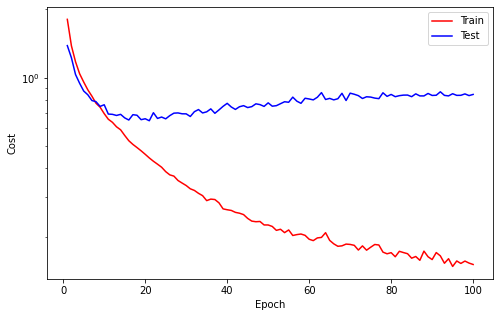

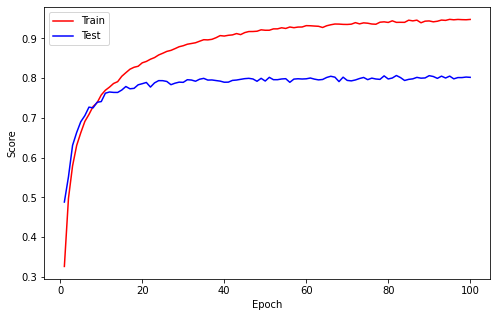

==> EarlyStop patience = 18 | Best test_score: 0.8067




Epoch   101
Train_cost  = 0.1483 | Test_cost  = 0.8873 | Train_score = 0.9481 | Test_score = 0.8011 |
==> EarlyStop patience = 19 | Best test_score: 0.8067




Epoch   102
Train_cost  = 0.1643 | Test_cost  = 0.8765 | Train_score = 0.9441 | Test_score = 0.8005 |
==> EarlyStop patience = 20 | Best test_score: 0.8067




Epoch   103
Train_cost  = 0.1525 | Test_cost  = 0.8767 | Train_score = 0.9468 | Test_score = 0.8071 |




Epoch   104
Train_cost  = 0.1426 | Test_cost  = 0.8896 | Train_score = 0.9498 | Test_score = 0.7997 |
==> EarlyStop patience =  1 | Best test_score: 0.8071




Epoch   105
Train_cost  = 0.1546 | Test_cost  = 0.8621 | Train_score = 0.9470 | Test_score = 0.8023 |
==> EarlyStop patience =  2 | Best test_score: 0.8071




Epoch   106
Train_cost  = 0.1408 | Test_cost  = 0.8784 | Train_score = 0.9512 | Test_score = 0.8018 |
==> EarlyStop patience =  3 | Best test_score: 0.8071




Epoch   107
Train_cost  = 0.1518 | Test_cost  = 0.8416 | Train_score = 0.9484 | Test_score = 0.8060 |
==> EarlyStop patience =  4 | Best test_score: 0.8071




Epoch   108
Train_cost  = 0.1454 | Test_cost  = 0.8821 | Train_score = 0.9504 | Test_score = 0.8053 |
==> EarlyStop patience =  5 | Best test_score: 0.8071




Epoch   109
Train_cost  = 0.1517 | Test_cost  = 0.8895 | Train_score = 0.9471 | Test_score = 0.7984 |
==> EarlyStop patience =  6 | Best test_score: 0.8071




Epoch   110
Train_cost  = 0.1514 | Test_cost  = 0.8337 | Train_score = 0.9477 | Test_score = 0.8059 |
==> EarlyStop patience =  7 | Best test_score: 0.8071




Epoch   111
Train_cost  = 0.1414 | Test_cost  = 0.9032 | Train_score = 0.9512 | Test_score = 0.8011 |
==> EarlyStop patience =  8 | Best test_score: 0.8071




Epoch   112
Train_cost  = 0.1334 | Test_cost  = 0.8706 | Train_score = 0.9542 | Test_score = 0.7994 |
==> EarlyStop patience =  9 | Best test_score: 0.8071




Epoch   113
Train_cost  = 0.1370 | Test_cost  = 0.8749 | Train_score = 0.9531 | Test_score = 0.7998 |
==> EarlyStop patience = 10 | Best test_score: 0.8071




Epoch   114
Train_cost  = 0.1477 | Test_cost  = 0.8835 | Train_score = 0.9501 | Test_score = 0.8055 |
==> EarlyStop patience = 11 | Best test_score: 0.8071




Epoch   115
Train_cost  = 0.1475 | Test_cost  = 0.8399 | Train_score = 0.9500 | Test_score = 0.8028 |
==> EarlyStop patience = 12 | Best test_score: 0.8071




Epoch   116
Train_cost  = 0.1493 | Test_cost  = 0.8542 | Train_score = 0.9495 | Test_score = 0.8003 |
==> EarlyStop patience = 13 | Best test_score: 0.8071




Epoch   117
Train_cost  = 0.1415 | Test_cost  = 0.8724 | Train_score = 0.9515 | Test_score = 0.8055 |
==> EarlyStop patience = 14 | Best test_score: 0.8071




Epoch   118
Train_cost  = 0.1442 | Test_cost  = 0.8389 | Train_score = 0.9501 | Test_score = 0.8007 |
==> EarlyStop patience = 15 | Best test_score: 0.8071




Epoch   119
Train_cost  = 0.1427 | Test_cost  = 0.8503 | Train_score = 0.9513 | Test_score = 0.8024 |
==> EarlyStop patience = 16 | Best test_score: 0.8071




Epoch   120
Train_cost  = 0.1408 | Test_cost  = 0.8654 | Train_score = 0.9511 | Test_score = 0.8027 |
==> EarlyStop patience = 17 | Best test_score: 0.8071




Epoch   121
Train_cost  = 0.1376 | Test_cost  = 0.8822 | Train_score = 0.9524 | Test_score = 0.7951 |
==> EarlyStop patience = 18 | Best test_score: 0.8071




Epoch   122
Train_cost  = 0.1391 | Test_cost  = 0.8803 | Train_score = 0.9534 | Test_score = 0.7985 |
==> EarlyStop patience = 19 | Best test_score: 0.8071




Epoch   123
Train_cost  = 0.1454 | Test_cost  = 0.8335 | Train_score = 0.9497 | Test_score = 0.8030 |
==> EarlyStop patience = 20 | Best test_score: 0.8071




Epoch   124
Train_cost  = 0.1415 | Test_cost  = 0.8775 | Train_score = 0.9517 | Test_score = 0.7997 |
==> EarlyStop patience = 21 | Best test_score: 0.8071




Epoch   125
Train_cost  = 0.1382 | Test_cost  = 0.8758 | Train_score = 0.9534 | Test_score = 0.8060 |
==> EarlyStop patience = 22 | Best test_score: 0.8071




Epoch   126
Train_cost  = 0.1453 | Test_cost  = 0.8799 | Train_score = 0.9503 | Test_score = 0.7931 |
==> EarlyStop patience = 23 | Best test_score: 0.8071




Epoch   127
Train_cost  = 0.1395 | Test_cost  = 0.8699 | Train_score = 0.9528 | Test_score = 0.8044 |
==> EarlyStop patience = 24 | Best test_score: 0.8071




Epoch   128
Train_cost  = 0.1315 | Test_cost  = 0.8911 | Train_score = 0.9555 | Test_score = 0.8064 |
==> EarlyStop patience = 25 | Best test_score: 0.8071
==> Execute Early Stopping at epoch: 128 | Best test_score: 0.8071
==> Best model is saved at model_weight


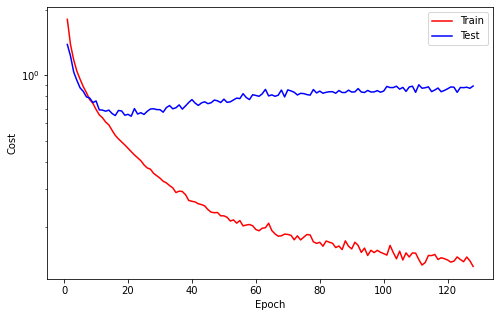

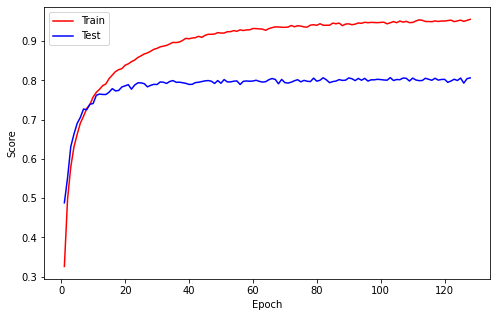

In [18]:
while True:
    train_cost, train_score = loop_fn("train", train_set, trainloader, model, criterion, optimizer, device)
    with torch.no_grad():
        test_cost, test_score = loop_fn("test", test_set, testloader, model, criterion, optimizer, device)
    
    # Logging
    callback.log(train_cost, test_cost, train_score, test_score)

    # Checkpoint
    callback.save_checkpoint()
        
    # Runtime Plotting
    callback.cost_runtime_plotting()
    callback.score_runtime_plotting()
    
    # Early Stopping
    if callback.early_stopping(model, monitor="test_score"):
        callback.plot_cost()
        callback.plot_score()
        break

## Prediksi

In [19]:
import matplotlib.pyplot as plt
import seaborn as sns

In [20]:
feature, target = next(iter(testloader))
feature, target = feature.to(device), target.to(device)

In [21]:
with torch.no_grad():
    model.eval()
    output = model(feature)
    preds = output.argmax(1)

preds

/usr/local/lib/python3.6/dist-packages/torch/nn/modules/container.py:117: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


tensor([4, 9, 0, 5, 7, 5, 0, 0, 4, 9, 4, 6, 4, 4, 1, 7, 1, 3, 4, 3, 6, 7, 7, 6,
        6, 8, 4, 2, 8, 2, 0, 9, 9, 1, 3, 6, 8, 1, 4, 4, 7, 5, 0, 0, 9, 1, 4, 6,
        4, 8, 0, 8, 5, 3, 5, 9, 9, 2, 1, 5, 7, 4, 3, 5, 0, 4, 6, 9, 1, 4, 5, 6,
        1, 0, 0, 6, 5, 3, 0, 5, 9, 8, 6, 1, 3, 0, 2, 8, 0, 0, 9, 1, 1, 9, 2, 2,
        4, 4, 8, 3, 9, 3, 9, 0, 1, 4, 8, 0, 3, 5, 2, 7, 5, 8, 5, 4, 1, 2, 7, 9,
        4, 8, 2, 8, 4, 4, 9, 6, 1, 1, 9, 0, 8, 5, 0, 4, 5, 9, 5, 4, 3, 8, 2, 7,
        0, 2, 8, 1, 8, 1, 3, 4, 1, 3, 0, 1, 1, 5, 5, 1, 7, 4, 4, 0, 2, 3, 5, 0,
        3, 1, 0, 7, 4, 1, 8, 5, 6, 6, 4, 7, 4, 5, 2, 3, 6, 2, 1, 0, 5, 2, 3, 9,
        5, 1, 8, 3, 0, 3, 5, 1, 6, 2, 1, 9, 7, 3, 5, 6, 1, 9, 3, 9, 9, 6, 1, 5,
        1, 5, 2, 4, 1, 0, 4, 6, 0, 7, 5, 6, 0, 3, 6, 6, 9, 1, 8, 7, 2, 4, 2, 2,
        5, 2, 2, 6, 0, 2, 5, 8, 8, 2, 9, 3, 0, 5, 5, 7, 7, 9, 0, 3, 6, 0, 8, 4,
        9, 9, 6, 1, 4, 7, 5, 7, 7, 8, 0, 6, 8, 9, 5, 3, 3, 8, 9, 3, 4, 0, 6, 4,
        7, 1, 4, 3, 7, 1, 6, 4, 2, 8, 1,

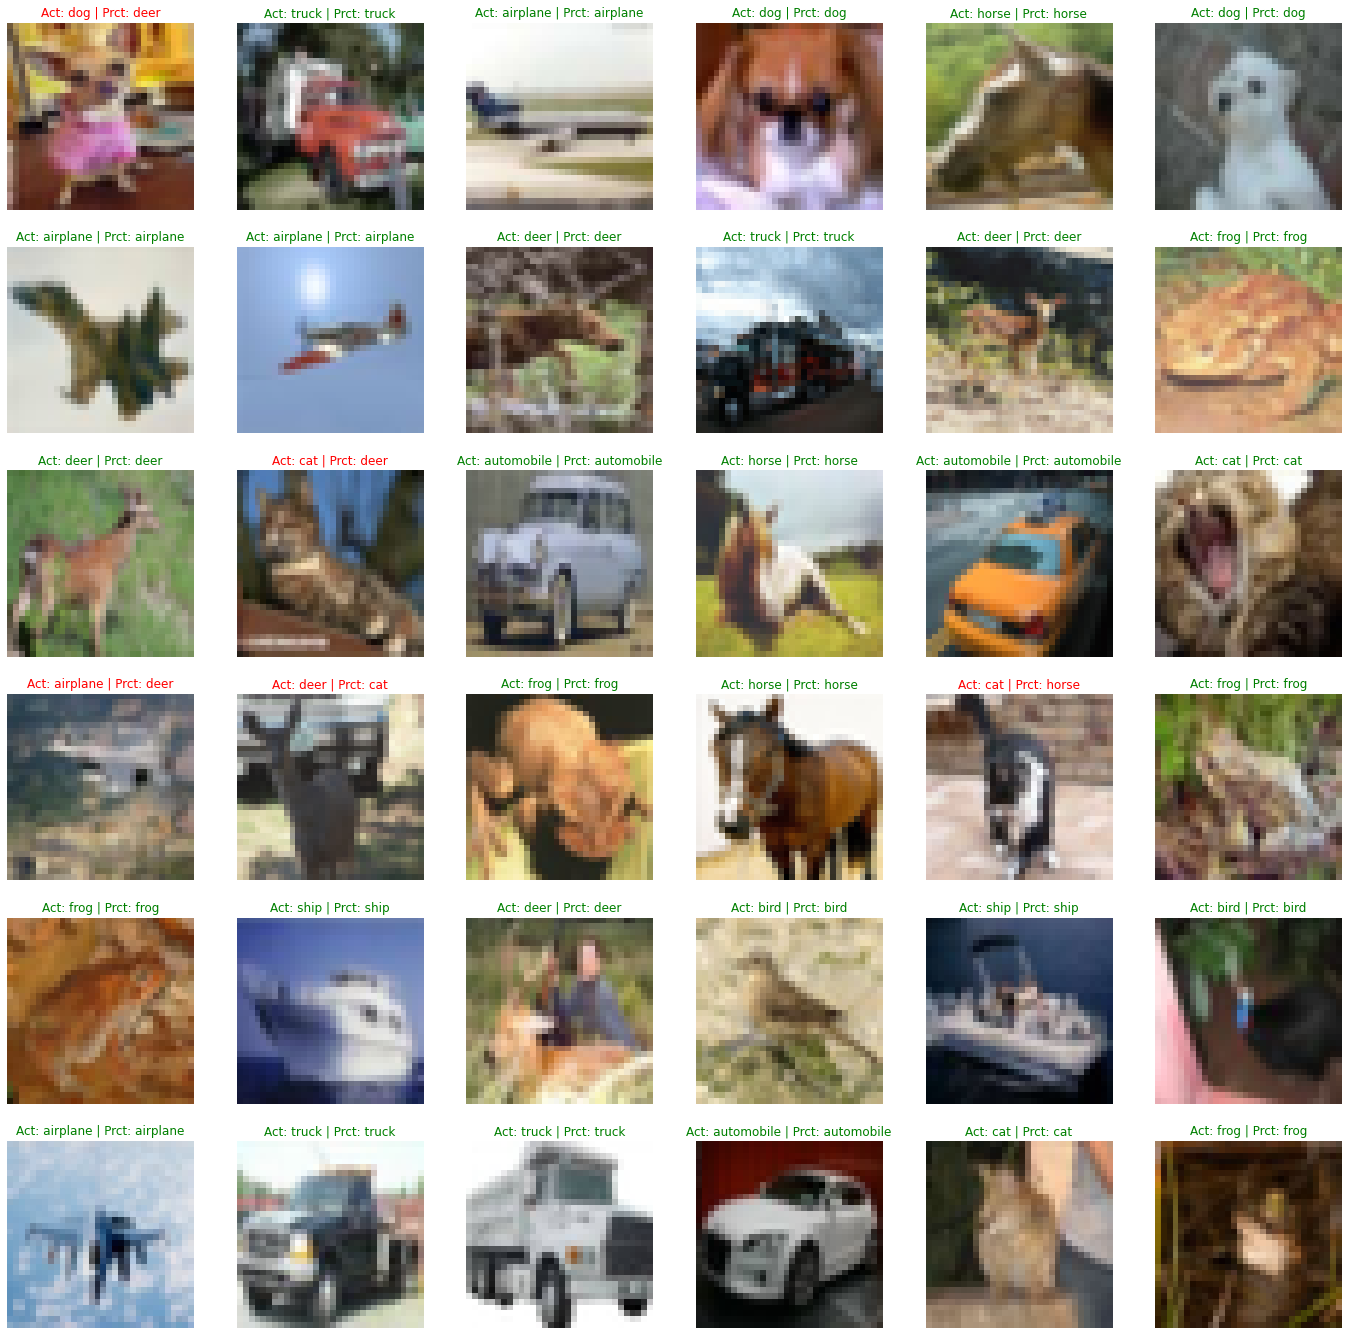

In [22]:
fig, axes = plt.subplots(6, 6, figsize=(24, 24))
for image, label, pred, ax in zip(feature, target, preds, axes.flatten()):
    ax.imshow(image.permute(1, 2, 0).cpu())
    font = {"color":"r"} if label != pred else {"color":"g"}
    label, pred = label2cat[label.item()], label2cat[pred.item()]
    ax.set_title(f"Act: {label} | Prct: {pred}", fontdict=font);
    ax.axis('off');